In [1]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import re
from model import ASRNeural
from utils import train_one_epoch, evaluate
from torchaudio import transforms as T

In [23]:
def generate(wave, many):
    model.eval()
    generated = [vocab['B']]

    for i in range(many):
        with torch.no_grad():
            preded = model(wave[0].to(device).unsqueeze(0), 
                           torch.LongTensor(generated).to(device).unsqueeze(0))
        if i != 0:
            argm = preded.squeeze().argmax(-1)[-1]
        else:
            argm = preded.squeeze().argmax(-1)
        if argm.item() == vocab['E']:
            break
        generated.append(argm.squeeze())
    generated = ''.join([itos[d] for d in generated if itos[d] != 'B'])
    return generated

In [3]:
specials = ["", "B", "E"]
bs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
data = pd.read_csv('new_data.csv')

In [5]:
data

,info,f_name
0,"Printing, in the only sense with which we are ...",LJ001-0001.wav
1,in being comparatively modern.,LJ001-0002.wav
2,For although the Chinese took impressions from...,LJ001-0003.wav
3,"produced the block books, which were the immed...",LJ001-0004.wav
4,the invention of movable metal letters in the ...,LJ001-0005.wav
...,...,...
13095,made certain recommendations which it believes...,LJ050-0274.wav
13096,materially improve upon the procedures in effe...,LJ050-0275.wav
13097,"As has been pointed out, the Commission has no...",LJ050-0276.wav
13098,with the active cooperation of the responsible...,LJ050-0277.wav


In [6]:
get_lower = lambda x: re.sub(r"[^a-z\s']", '', x.lower())
vocab = build_vocab_from_iterator(
    data['info'].apply(get_lower), special_first=True, specials=specials)
vocab.set_default_index(vocab[''])

In [7]:
vocab.get_itos()

['',
 'B',
 'E',
 ' ',
 'e',
 't',
 'a',
 'o',
 'n',
 'i',
 's',
 'r',
 'h',
 'd',
 'l',
 'c',
 'f',
 'u',
 'm',
 'w',
 'p',
 'g',
 'y',
 'b',
 'v',
 'k',
 'x',
 'q',
 'j',
 "'",
 'z']

In [8]:
itos = vocab.get_itos()

In [9]:
train_data = data.iloc[:10000]

In [10]:
valid_data = data.iloc[10000:11500]

In [11]:
class LJSpeechSet(Dataset):
    def __init__(self, data, phase='train'):
        
        pathx = 'LJSpeech-1.1/wavs/'
        self.data = dict()
        self.wave_forms, self.labels, self.sample_rates = list(), list(), list()

        for i, row in data.iterrows():

            wave_form, s_r = torchaudio.load(pathx + str(row['f_name']))
            label = torch.LongTensor([vocab[c] for c in "B"+
                                      re.sub(r"[^a-z\s']", '', str(row['info'].lower()))+"E"])

            self.wave_forms.append(wave_form.squeeze()), self.labels.append(label), self.sample_rates.append(s_r)


        self.phase = phase
        self.wave_forms = pad_sequence(self.wave_forms, batch_first=True)

    def __len__(self):
        return len(self.wave_forms)
    
    def __getitem__(self, ind):
        return self.wave_forms[ind], self.labels[ind], self.sample_rates[ind]

In [12]:
train_set = torch.load('train_set')
valid_set = torch.load('valid_set')

In [13]:
def collate(batch):
    mel_waves = pad_sequence([b[0] for b in batch], batch_first=True).unsqueeze(1)
    labels = pad_sequence([b[1] for b in batch], batch_first=True, padding_value=vocab[''])
    rates = [b[2] for b in batch]
    return mel_waves, labels, rates

In [14]:
train_loader = DataLoader(train_set, bs, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_set, bs, shuffle=True, collate_fn=collate)

In [15]:
model = ASRNeural(len(vocab)).to(device)

/home/vahid/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (151) may be set too low.
  warnings.warn(
/home/vahid/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
model = torch.load('modelx1.pt')

In [ ]:
model

In [17]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [18]:
loss_train_hist = list()
loss_valid_hist = list()
pre_train_hist = list()
pre_valid_hist = list()
best_loss_valid = 1e+4
epoch_counter = 0

In [ ]:
n = 100
for epoch in range(n):
    model, train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss = evaluate(model, valid_loader, loss_fn)
    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)

    if valid_loss < best_loss_valid:
        torch.save(model,'modelx1.pt')
        best_loss_valid =  valid_loss
        print('Model SAVED') 

    epoch_counter +=1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
plt.plot(loss_train_hist, label='train')
plt.plot(loss_valid_hist, label='validation')
plt.legend()
plt.grid(True)

In [19]:
sum(p.numel() for p in model.parameters())

29437875

In [24]:
wave, label, sr = next(iter(valid_loader))

In [25]:
generate(wave, 250)

'the constitution of the prisoners of the prisoners of the prisoners of the prisoners of the prisoners'

In [26]:
''.join([itos[d] for d in label[0] if itos[d] != 'E' and itos[d] != 'B'])

'marguerite oswald worked in miscellaneous jobs after her divorce from ekdahl'

In [27]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

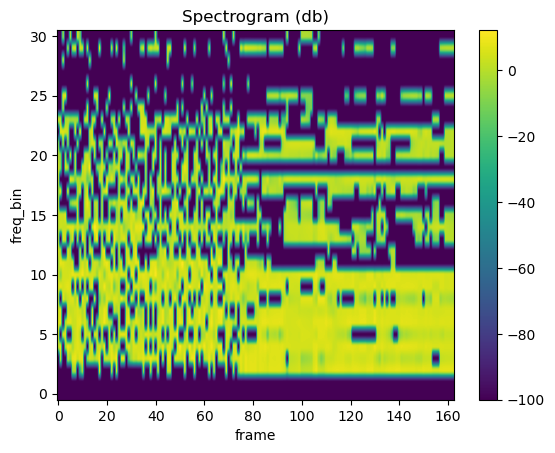

In [28]:
plot_spectrogram(model(wave[0].to(device).unsqueeze(0), 
                       label[0].unsqueeze(0).to(device)).permute(0, 2, 1).detach().cpu()[0])